In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm.keras import TqdmCallback
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from PIL import Image
from numpy import asarray

In [79]:
df = pd.read_csv('facial_keypoints.csv')
df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [80]:
df = df.fillna(0)

In [81]:
c = 0
columns = {}
temp = []
for i, e in enumerate(list(df.columns)):
    temp.append(e)
    c += 1
    if c == 2:
        columns[e.split('_y')[0]] = temp
        temp = []
        c = 0

In [82]:
keypoints_dict = {}
for k in columns.keys():
    keypoints_dict[k] = df[columns[k]].values

keypoints = np.array(list(keypoints_dict.values()))
keypoints = np.swapaxes(keypoints, 0, 1)
features = np.load('face_images.npz')['face_images']
features = np.swapaxes(np.swapaxes(features, 1, 2), 0, 1)

In [83]:
keypoints = keypoints.reshape(-1, 30)
print(keypoints[0])
features = features.reshape(7049, 96, 96, 1)

[66.03356391 39.00227368 30.22700752 36.4216782  59.58207519 39.64742256
 73.13034586 39.96999699 36.35657143 37.3894015  23.45287218 37.3894015
 56.95326316 29.03364812 80.22712782 32.22813835 40.22760902 29.0023218
 16.35637895 29.64747068 44.42057143 57.06680301 61.19530827 79.97016541
 28.61449624 77.38899248 43.3126015  72.93545865 43.13070677 84.48577444]


In [84]:
X_train, X_test, y_train, y_test = train_test_split(features, keypoints, test_size=0.1)
img_size = 96

In [85]:
model = Sequential()
model.add(Input(shape=(img_size, img_size, 1)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3,3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  
model.add(Flatten())
model.add(Dense(128,kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5)) 
model.add(Dense(64,kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0))
model.add(Dense(30,kernel_initializer=glorot_uniform()))
model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mean_squared_error', 'accuracy'])
checkpoint_filepath = 'weights.{val_accuracy:.2f}.h5'

mcc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [86]:
BATCH_SIZE = 32
EPOCHS = 10

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    shuffle=True,
    verbose=1,
    callbacks=[mcc]
)

Epoch 1/10
 37/199 [====>.........................] - ETA: 56s - loss: 894.4995 - mean_squared_error: 894.4995 - accuracy: 0.4975

KeyboardInterrupt: 

(30,)
(96, 96, 1)
[[ 58.67894     34.53369   ]
 [ 28.438889    34.000618  ]
 [ -3.4458282   -0.5881285 ]
 [ -2.6741233    1.7720646 ]
 [ -3.9923594   -0.07584051]
 [ -1.720168    -0.657776  ]
 [ -4.4024615   -0.73392296]
 [ -3.4345362    0.2299818 ]
 [ -4.739034    -1.4417174 ]
 [ -1.9870317   -0.3232062 ]
 [ 44.343655    57.781418  ]
 [ -4.835074   -10.037081  ]
 [ -2.3500533   -5.9182615 ]
 [ -1.5587925   -6.9191327 ]
 [ 42.14755     66.7318    ]]


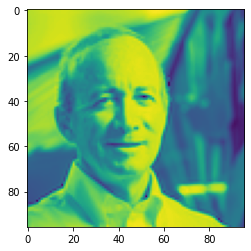

In [65]:
model.load_weights("weights.0.90.h5")
img = Image.open('dd.png')
im = asarray(img.split()[0])
plt.imshow(im)
im = im.reshape(1, 96, 96, 1)
kp = model.predict(im)
kp = kp.reshape(15, 2)
print(kp)

In [68]:
model.load_weights("weights.0.90.h5")
a = features[0].reshape(1, 96, 96, 1)
b = keypoints[0]
print(model.predict(a))
print(b)

[[58.32623   33.864807  23.982756  32.613815   7.05027    4.9581413
  11.69327    2.9803627  4.17597    7.1245117  4.043091   1.9654247
  11.593609   4.3577375 10.337744   7.2831845  7.832199   3.5172563
   2.8874757  2.9140859 39.60401   56.995705   8.928643  12.8837185
   4.540076  14.016769   6.995219  12.955138  40.987003  72.87665  ]]
[66.03356391 39.00227368 30.22700752 36.4216782  59.58207519 39.64742256
 73.13034586 39.96999699 36.35657143 37.3894015  23.45287218 37.3894015
 56.95326316 29.03364812 80.22712782 32.22813835 40.22760902 29.0023218
 16.35637895 29.64747068 44.42057143 57.06680301 61.19530827 79.97016541
 28.61449624 77.38899248 43.3126015  72.93545865 43.13070677 84.48577444]
